# Выпускной проект <br>Тема: Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. 

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около **100 тонн**. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и **подогревают до нужной температуры графитовыми электродами**. Они установлены в крышке ковша. 

Из сплава выводится **сера (десульфурация)**, **добавлением примесей** корректируется химический состав и **отбираются пробы**. Сталь **легируют** — изменяют её состав — подавая **куски сплава** из бункера для сыпучих материалов или **проволоку** через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как **первый раз** ввести **легирующие добавки**, **измеряют температуру** стали и производят её **химический анализ**. Потом **температуру на несколько минут повышают**, **добавляют легирующие** материалы и **продувают** сплав **инертным газом**. Затем его **перемешивают** и снова **проводят измерения**. Такой **цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки**.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Цель работы:**

Построить модель, которая предскажет температуру стали.

**Задача работы:**

Достижение значения средней абсолютной погрешности (MAE) менее 8.7 градусов.

**Критерии оценки качества предсказаний модели:**

$\displaystyle\qquad\;MAE > 8.7\ -0\ sp$  
$\displaystyle 7.6 < MAE \leq 8.7\ - 4\ sp$  
$\displaystyle 6.8 < MAE \leq 7.6\ - 4.5\ sp$  
$\displaystyle 6.3 < MAE \leq 6.8\ - 5\ sp$  
$\displaystyle 6.0 < MAE \leq 6.3\ - 5.5\ sp$  
$\displaystyle\qquad\;MAE \leq 6.0\ - 6\ sp$  

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.
<a name="contents"></a>
### Оглавление 

1. [План работы](#plan)
2. [Анализ исходных данных](#analysis)
3. [Подготовка данных](#processing)
4. [Построение модели](#model)
5. [Вывод](#conclusion)

## Анализ исходных данных 
<a name="analysis"></a>
[К оглавлению](#contents)

Загружаем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import date
import time


from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV

from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, cv

from sklearn.metrics import mean_absolute_error


import warnings
warnings.filterwarnings('ignore')

Подгуружаем исходные датасеты

In [2]:
try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except:
    data_arc = pd.read_csv('C:/Users/shev/Desktop/Yandex_pract/final/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('C:/Users/shev/Desktop/Yandex_pract/final/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('C:/Users/shev/Desktop/Yandex_pract/final/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('C:/Users/shev/Desktop/Yandex_pract/final/final_steel/data_gas.csv')
    data_temp = pd.read_csv('C:/Users/shev/Desktop/Yandex_pract/final/final_steel/data_temp.csv')
    data_wire = pd.read_csv('C:/Users/shev/Desktop/Yandex_pract/final/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('C:/Users/shev/Desktop/Yandex_pract/final/final_steel/data_wire_time.csv')    
    
    
d_n = {'data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time'} # чтобы под рукой был список датасетов

Создаём функцию для первичного просмотра датафреймоф

In [3]:
def analysis(name):
    name.info()
    display(name.head())
    display(name.describe().round(2))
    if name.shape[1] != name.describe().shape[1]:
        display(name.describe(include=['object', 'bool']))

### Мощность

In [4]:
analysis(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Активная мощность,Реактивная мощность
count,14876.00,14876.00,14876.00
mean,1615.22,0.67,0.45
std,934.57,0.41,5.88
min,1.00,0.03,-715.50
25%,806.00,0.40,0.29
50%,1617.00,0.56,0.42
75%,2429.00,0.86,0.64
max,3241.00,3.73,2.68


,Начало нагрева дугой,Конец нагрева дугой
count,14876,14876
unique,14875,14876
top,2019-06-10 22:02:03,2019-05-31 21:03:40
freq,2,1


Посмотрим количество ключей

In [5]:
len(data_arc['key'].unique())

3214

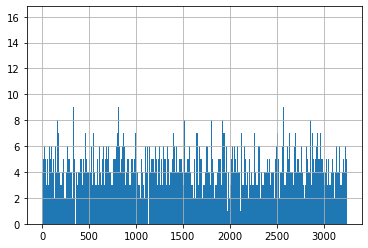

In [6]:
data_arc['key'].hist(bins=data_temp['key'].max())
plt.show()

Посмотрим данные c отрицательной реактивной мощностью.

In [7]:
data_arc[data_arc['Реактивная мощность'] < 0].head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [8]:
data_arc[data_arc['key'] == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


In [9]:
(data_arc[data_arc['key'] == 2116]['Активная мощность'] / 
data_arc[data_arc['key'] == 2116]['Реактивная мощность']) 

9778    1.415252
9779    1.518947
9780   -0.000693
9781    1.505906
dtype: float64

Посмотрим данные с повторяющей датой начала нагрева

In [10]:
data_arc[data_arc['Начало нагрева дугой'] == '2019-06-10 22:02:03']

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
4872,1051,2019-06-10 22:02:03,2019-06-10 22:06:02,1.040376,0.635608
4876,1052,2019-06-10 22:02:03,2019-06-10 22:04:31,0.623495,0.508767


In [11]:
data_arc.query(' 1051<= key <= 1052')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
4866,1051,2019-06-10 21:10:52,2019-06-10 21:16:30,1.448011,1.045037
4867,1051,2019-06-10 21:17:31,2019-06-10 21:24:27,2.003559,1.248206
4868,1051,2019-06-10 21:25:37,2019-06-10 21:30:51,1.528554,0.892720
4869,1051,2019-06-10 21:32:03,2019-06-10 21:36:58,1.417861,0.818525
4870,1051,2019-06-10 21:53:30,2019-06-10 21:54:50,0.337850,0.198380
4871,1051,2019-06-10 21:55:47,2019-06-10 22:00:57,1.352988,0.823782
4872,1051,2019-06-10 22:02:03,2019-06-10 22:06:02,1.040376,0.635608
4873,1052,2019-06-10 21:46:15,2019-06-10 21:52:20,1.292979,1.094674
4874,1052,2019-06-10 21:53:58,2019-06-10 21:58:07,1.098052,0.737462
4875,1052,2019-06-10 21:59:46,2019-06-10 22:00:20,0.134783,0.092384


Очень странно, считал что партии по времени не должны пересекаться, а здесь видно, что 1051 партия варится "одновременно" с 1052.

**Промежуточный вывовод по файлу data_arc:**

1. Фаил содержит 5 столбцов и 14876 строк.
2. Пропусков нет.
3. Для ключа 2116 присутствует ошибка в записи реактивной мощности. Ошибка некритичная, можно устронить, изменив значение на среднее между соседними итерациями.
4. Всего в файле представлны данные о 3214 ключах.
5. В среднем данные по плавке выведены по 3-4 итерациям.

Посммотрим данные в таблице подачи сыпучих материалов

### Сыпучие материалы

In [12]:
analysis(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.00,252.00,22.00,1298.00,1014.00,77.00,576.00,25.00,1.0,19.00,176.00,177.00,2450.00,18.00,2806.00,2248.00
mean,1624.38,39.24,253.05,113.88,104.39,107.03,118.93,305.60,49.0,76.32,83.28,76.82,260.47,181.11,170.28,160.51
std,933.34,18.28,21.18,75.48,48.18,81.79,72.06,191.02,NaN,21.72,26.06,59.66,120.65,46.09,65.87,51.77
min,1.00,10.00,228.00,6.00,12.00,11.00,17.00,47.00,49.0,63.00,24.00,8.00,53.00,151.00,16.00,1.00
25%,816.00,27.00,242.00,58.00,72.00,70.00,69.75,155.00,49.0,66.00,64.00,25.00,204.00,153.25,119.00,105.00
50%,1622.00,31.00,251.50,97.50,102.00,86.00,100.00,298.00,49.0,68.00,86.50,64.00,208.00,155.50,151.00,160.00
75%,2431.00,46.00,257.75,152.00,133.00,132.00,157.00,406.00,49.0,70.50,102.00,106.00,316.00,203.50,205.75,205.00
max,3241.00,185.00,325.00,454.00,281.00,603.00,503.00,772.00,49.0,147.00,159.00,313.00,1849.00,305.00,636.00,405.00


Смотреть неудобно отсортируем по частоте использования смеси

In [13]:
data_bulk.describe().round(1).sort_values('count', axis=1, ascending=False)

,key,Bulk 14,Bulk 12,Bulk 15,Bulk 3,Bulk 4,Bulk 6,Bulk 1,Bulk 11,Bulk 10,Bulk 5,Bulk 7,Bulk 2,Bulk 9,Bulk 13,Bulk 8
count,3129.0,2806.0,2450.0,2248.0,1298.0,1014.0,576.0,252.0,177.0,176.0,77.0,25.0,22.0,19.0,18.0,1.0
mean,1624.4,170.3,260.5,160.5,113.9,104.4,118.9,39.2,76.8,83.3,107.0,305.6,253.0,76.3,181.1,49.0
std,933.3,65.9,120.6,51.8,75.5,48.2,72.1,18.3,59.7,26.1,81.8,191.0,21.2,21.7,46.1,NaN
min,1.0,16.0,53.0,1.0,6.0,12.0,17.0,10.0,8.0,24.0,11.0,47.0,228.0,63.0,151.0,49.0
25%,816.0,119.0,204.0,105.0,58.0,72.0,69.8,27.0,25.0,64.0,70.0,155.0,242.0,66.0,153.2,49.0
50%,1622.0,151.0,208.0,160.0,97.5,102.0,100.0,31.0,64.0,86.5,86.0,298.0,251.5,68.0,155.5,49.0
75%,2431.0,205.8,316.0,205.0,152.0,133.0,157.0,46.0,106.0,102.0,132.0,406.0,257.8,70.5,203.5,49.0
max,3241.0,636.0,1849.0,405.0,454.0,281.0,503.0,185.0,313.0,159.0,603.0,772.0,325.0,147.0,305.0,49.0


В данной таблице представлена информация по 3129 партиям (на 85 меньше чем в таблице с данными по электродам). Сразу кидается в глаза большое количество пропусков. Из представленных сыпучих матеиалов, только 5 видов добавлялись более чем в 50% случаев.

Посмотрим корреляцию

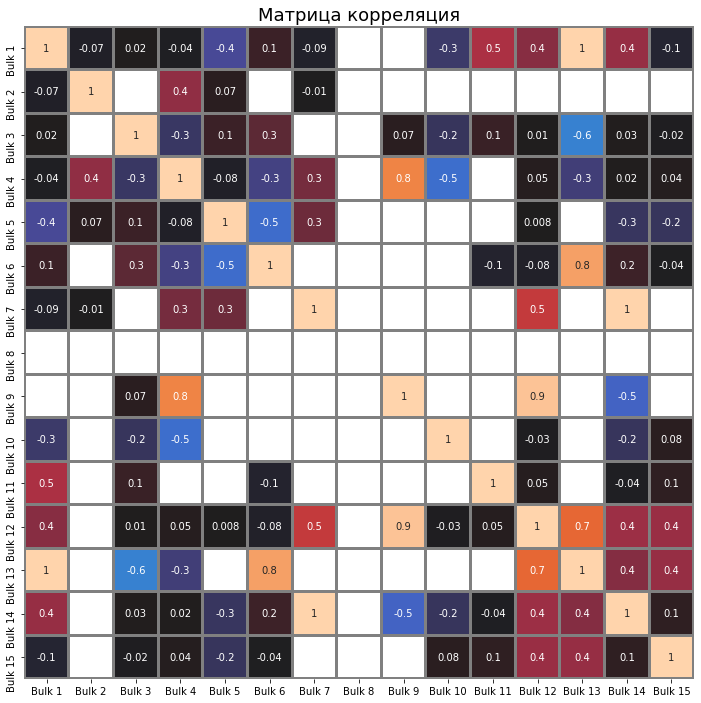

In [14]:
plt.figure(figsize=(12, 12))
(
sns.heatmap(data_bulk.drop(['key'], axis=1).corr(), 
            annot=True, fmt='.1g', 
            vmin=-1, 
            vmax=1, 
            center= 0, 
            linewidths=2, 
            linecolor='grey', 
            cbar=False).
set_title('Матрица корреляция', fontsize=18) 
)
plt.show()

Получилась интересная картина. Существуют данные, которые имеют высокую степень корреляции (линейную), к сожелению "сильно" корреллируются только популярные с непопулярными смесями.

В целом такое кол-во признаков оставлять нерационально, поэтому либо существенно сокращу их путём частичного сложения, либо оставлю один признак сложив все используемые смеси для каждой партии, либо оставлю самые популярные признаки. Решение не принято.

Посмотрел распределения для самых популярных смесей. Оставил самый интересный.

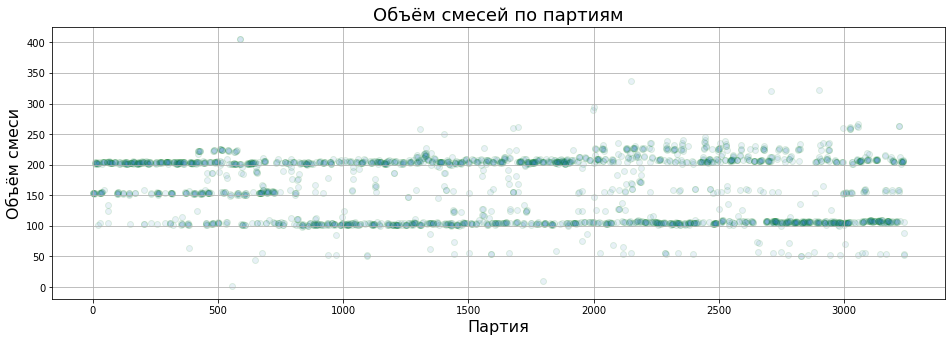

In [15]:
plt.figure(figsize=(16, 5))
#plt.scatter(x=data_bulk['key'],
#            y=data_bulk['Bulk 14'],
#            alpha=0.1,
#            edgecolors = 'b')

#plt.scatter(x=data_bulk['key'],
#            y=data_bulk['Bulk 12'],
#            alpha=0.1,
#            edgecolors = 'red')

plt.scatter(x=data_bulk['key'],
            y=data_bulk['Bulk 15'],
            alpha=0.1,
            edgecolors = 'g')

plt.xlabel('Партия', fontsize=16)
plt.ylabel('Объём смеси', fontsize=16)
plt.title('Объём смесей по партиям', fontsize=18)
##plt.legend(['Оценки пользователей', 'Оценки критиков'], fontsize=14)
plt.grid(True)
plt.show()

In [16]:
analysis(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key
count,3129.00
mean,1624.38
std,933.34
min,1.00
25%,816.00
50%,1622.00
75%,2431.00
max,3241.00


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
top,2019-06-13 13:35:57,2019-08-08 14:33:22,2019-06-04 06:29:32,2019-05-25 21:50:10,2019-05-11 21:33:53,2019-08-21 07:34:27,2019-08-08 10:27:58,2019-07-05 17:46:11,2019-05-14 01:09:57,2019-07-31 15:59:07,2019-07-24 04:36:00,2019-07-28 09:39:45,2019-05-05 00:39:35,2019-07-28 09:39:45,2019-07-28 09:39:45
freq,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [17]:
z = []
for i in range(len(data_bulk)):
    if data_bulk.iloc[i]['key'] != data_bulk_time.iloc[i]['key']:
        z.append(i)
z

[]

Ключи совпадают. Данный фаил не пригодится для обучения модели.

### Газ

In [18]:
analysis(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.00,3239.00
mean,1621.86,11.00
std,935.39,6.22
min,1.00,0.01
25%,812.50,7.04
50%,1622.00,9.84
75%,2431.50,13.77
max,3241.00,78.00


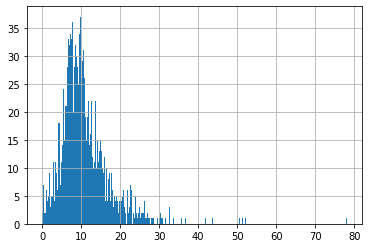

In [19]:
data_gas['Газ 1'].hist(bins=780)
plt.show()

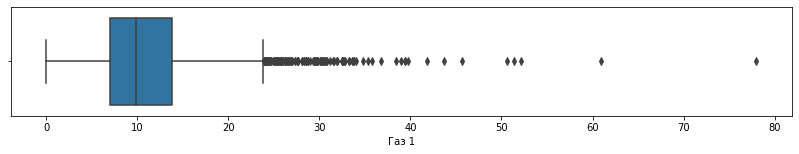

In [20]:
plt.figure(figsize=(14,2))
sns.boxplot(x=data_gas['Газ 1'])
plt.show()

In [21]:
len(data_gas[data_gas['Газ 1'] > 24])

122

Пока что сложно что-то сказать, кроме того, что наблюдается небольшое кол-во выбросов.

### Температура

In [22]:
analysis(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Температура
count,15907.00,13006.00
mean,1607.88,1591.84
std,942.21,21.38
min,1.00,1191.00
25%,790.00,1581.00
50%,1618.00,1591.00
75%,2427.00,1601.00
max,3241.00,1705.00


,Время замера
count,15907
unique,15907
top,2019-05-13 19:19:21
freq,1


А вот и фаил, в котором скрывается наш целевой признак. Всего имеются записи о 15907 наблюдениях. При этом информация о температуре имеется всегего в 13006 строках. Согласно поставленному условию исследования нас интересует в качестве целевого признака температура последней итерации. В качестве одного из признаков для обучения моделей будем использовать температуру первой итерации. 

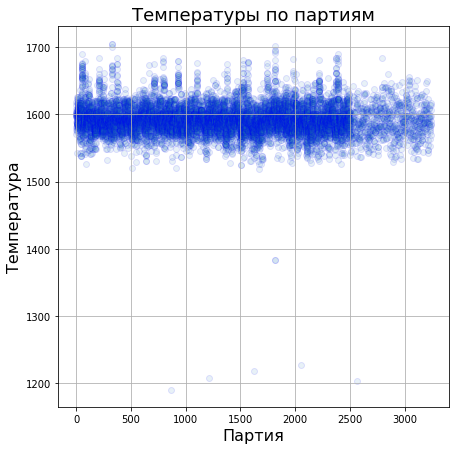

In [23]:
plt.figure(figsize=(7, 7))

plt.scatter(x=data_temp['key'],
            y=data_temp['Температура'],
            alpha=0.1,
            edgecolors = 'b')

plt.xlabel('Партия', fontsize=16)
plt.ylabel('Температура', fontsize=16)
plt.title('Температуры по партиям', fontsize=18)
plt.grid(True)
plt.show()

Похоже, что подавляющее число пропусков находится за 2500 ключом. Проверим.

In [24]:
data_temp[data_temp['Температура'].isnull()].head()

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN


Подтверждено, все пропуски начинаются с 2500 ключа. Проверим сколько температур представлено для ключей с пропусками и сколько всего ключей с пропусками.

In [25]:
len(data_temp.query('key > 2499').dropna())

739

In [26]:
len(data_temp.query('key > 2499')['key'].unique())

739

Значения равны, видимо Заказчик решил не предоставлять эти данные, а использовать их в качестве тестовой выборки. При обработке смело удалим данные для ключей после 2499. Посмотрим количество замеров температуры для каждой партии.

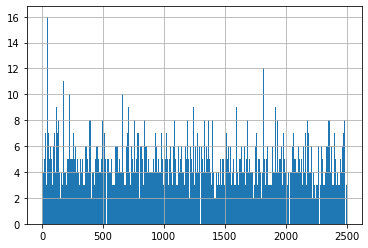

In [27]:
data_temp.query('key < 2500')['key'].hist(bins=2499)
plt.show()

В основном в каждой партиии делают 3 - 4 замера температуры.

Ради интереса посмотрим данные о каких партиях Заказчик нам не предоставил

In [28]:
keys = data_temp.query('key < 2500')['key'].unique()
missing_keys = []
for i in range(1,2500):
        if i not in keys:
            missing_keys.append(i)
missing_keys

[41,
 42,
 355,
 382,
 506,
 529,
 540,
 607,
 683,
 710,
 766,
 1133,
 1300,
 1437,
 2031,
 2103,
 2278,
 2356,
 2373,
 2446,
 2469,
 2491]

Посмотрим кол-во данных с температруой менее 1500 градусов.

In [29]:
data_temp.query('Температура < 1500')

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


**Промежуточный вывод:**
1. Все данные с ключом более 2499 содержат информацию лишь об одной температуре.
2. В выборке представлено 7 партий с зарегестрированной температурой ниже 1500 градусов хотя бы в одной из стадий процесса плавки.


### Проволка

In [30]:
analysis(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.00,3055.00,1079.00,63.00,14.00,1.00,73.00,11.00,19.00,29.00
mean,1623.43,100.90,50.58,189.48,57.44,15.13,48.02,10.04,53.63,34.16
std,933.00,42.01,39.32,99.51,28.82,NaN,33.92,8.61,16.88,19.93
min,1.00,1.92,0.03,0.14,24.15,15.13,0.03,0.23,45.08,4.62
25%,823.00,72.12,20.19,95.14,40.81,15.13,25.05,6.76,46.09,22.06
50%,1619.00,100.16,40.14,235.19,45.23,15.13,42.08,9.02,46.28,30.07
75%,2434.00,126.06,70.23,276.25,76.12,15.13,64.21,11.89,48.09,43.86
max,3241.00,330.31,282.78,385.01,113.23,15.13,180.45,32.85,102.76,90.05


In [31]:
len(data_wire['Wire 1'].dropna()) / len(data_wire)

0.9915611814345991

При плавке в основном используется проволка варианта 1 (применяется в 99 % случаем), в 30 % процентах используется проволка варианта 2, остальные практически не добавляются. Посмотрим на график по самым популярным проволкам.

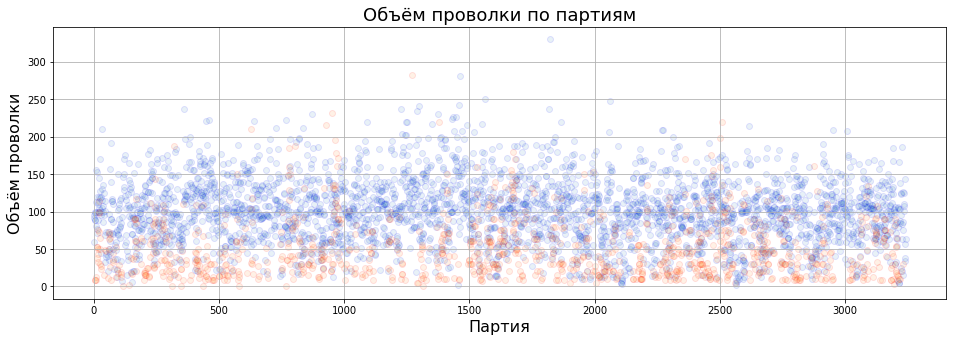

In [32]:
plt.figure(figsize=(16, 5))

plt.scatter(x=data_wire['key'],
            y=data_wire['Wire 1'],
            alpha=0.1,
            edgecolors = 'blue')

plt.scatter(x=data_wire['key'],
            y=data_wire['Wire 2'],
            alpha=0.1,
            edgecolors = 'red')

plt.xlabel('Партия', fontsize=16)
plt.ylabel('Объём проволки', fontsize=16)
plt.title('Объём проволки по партиям', fontsize=18)
##plt.legend(['Оценки пользователей', 'Оценки критиков'], fontsize=14)
plt.grid(True)
plt.show()

In [33]:
analysis(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.00
mean,1623.43
std,933.00
min,1.00
25%,823.00
50%,1619.00
75%,2434.00
max,3241.00


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055,1079,63,14,1,73,11,19,29
unique,3055,1079,63,14,1,73,11,19,29
top,2019-07-20 09:26:44,2019-05-27 14:06:50,2019-08-08 11:15:53,2019-07-17 07:15:28,2019-08-08 16:01:07,2019-05-07 15:48:13,2019-07-23 19:46:16,2019-08-11 13:20:31,2019-06-07 22:47:35
freq,1,1,1,1,1,1,1,1,1


In [34]:
z = []
for i in range(len(data_wire_time)):
    if data_wire.iloc[i]['key'] != data_wire_time.iloc[i]['key']:
        z.append(i)
z

[]

Ключи в файлах data_wire и data_wire_time совпадают.

### Вывод по разделу 2

1. Фаил с мощностью не модержит пропусков.
2. Для ключа 2116 присутствует ошибка в записи реактивной мощности. Ошибка некритичная, можно устронить, изменив значение на среднее между соседними итерациями.
3. В среднем данные по плавке выведены по 3-4 итерациям.
4. В данных по сыпучим материалам содержится большое кол-во. Пропуск указывают на то, что для данной плавки материал не использовался.
5. Наиболее популярные сыпучие смеси: Bulk 14, Bulk 12, Bulk 15, Bulk 3, Bulk 4.
6. Для данных по газу пропучсков нет.
7. В данных по проволкам содержится большое кол-во. Пропуск указывают на то, что для данной плавки проволка не использовалась.
8. Наиболее популярные проволки: Wire 1, Wire 2.
9. Данные по времени согласуются с данными по объёмам, что для сыпучих, что для проволки. В дальнейшей работе файлы data_bulk_time и data_wire_time использоваться не будут.

**План обработки:**

1. Пропуски в объёмах используемых материалов заменить на нули.
2. Для температуры оставть ключи до 2500
3. Исправить аномальное значение Реактивной мощности.
4. Посчитать время нагрева
5. Посчитать общую мощность
6. Создать новую таблицу для мощности с группировкой по ключам
7. Выделить для каждого ключа Температуру первого и последнего замеров
8. Сгрупироать данные для температуры по ключам
9. Исключить из рассмотрения информацию с температурой ниже 1500 градусов
10. Сгрупировать информацию по "непопулярным" провлкам, оставив основную
11. Сгрупировать информацию по "непопулярным" сыпучим материалам, оставив основные (в ходе работы опытным путём выяснил, что данную информацию лучше оставить без групировки)
12. Создать сводную таблицу признаков

 <a name="processing"></a>
## Подготовка данных
[К оглавлению](#contents)

### Борьба с пропусками

Ну здесь всё пропусто. Пропуски содержаться в датафреймах со смесями, проволкой и темпераурой. Для двух первых считаем, что раз нет информации по добавкам в данной варке, то они и не добавлялась - NaN заменяем на ноль. Для температуры выкидываем все ключи после 2499.

In [35]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

In [36]:
data_temp = data_temp.query('key < 2500')

### Удаление лишних данных
Займемся лишними данными, такими как дублирующиеся ключи и выбросы. Начнём с таблицы с мощностью.
#### Мощность

Для начала вспомним, что для 2116 ключа в таблице указано некорректное значение мощности, исправимс его. Возьмём среднее между отношением активной к реактивной мощности соседних ячеек и умножим получившееся значение значение активной мощности "*битой*" строки

In [37]:
arc = data_arc.copy()

In [38]:
arc.query('key == 2116')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


In [39]:
i_rp = 9780
arc.loc[i_rp, 'Реактивная мощность'] = (arc.loc[i_rp]['Активная мощность'] /
    (( arc.loc[i_rp-1]['Активная мощность'] / arc.loc[i_rp-1]['Реактивная мощность'] +
      arc.loc[i_rp+1]['Активная мощность'] / arc.loc[i_rp+1]['Реактивная мощность']) / 2)
   ).round(6)
arc.query('key == 2116')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,0.327806
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Сделано. Теперь исправим формат даты и посчитаем количество между началом и концом нагрева для каждой итерации

In [40]:
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [41]:
arc['time'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой'])
for i in range(len(arc['time'])):
    arc['time'].loc[i] = arc['time'].loc[i].total_seconds()

arc['time'] = arc['time'].astype('int')
arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57


Сделано. Посчитаем сумарную мощность для каждой итерации, как корень из суммы квадратов активной и реактивной мощностей.

In [42]:
arc['power'] = (arc['Активная мощность'] ** 2 + arc['Реактивная мощность'] ** 2) ** 0.5

arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,time,power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239
...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157,0.640648
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180,0.855559
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184,0.874560
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57,0.264489


Сделано. 

Теперь сгрупируем всё по ключам с суммированием, удалим столбцы с значениями активной и реактивной мощностей, и добавим столбец с количеством итераций.

In [43]:
arc = arc.groupby('key').sum().drop(['Активная мощность', 'Реактивная мощность'], axis=1)
arc['count'] = data_arc.groupby('key')['key'].count()
arc = arc.reset_index()

arc

,key,time,power,count
0,1,1098,5.826395,5
1,2,811,3.649216,4
2,3,655,2.989534,5
3,4,741,3.814962,4
4,5,869,4.035758,4
...,...,...,...,...
3209,3237,909,4.844982,5
3210,3238,546,2.696542,3
3211,3239,1216,5.611883,8
3212,3240,839,3.891856,5


Посмотрим распределение и проверим, что не потеряли ключи

In [44]:
arc.describe().round(1)

,key,time,power,count
count,3214.0,3214.0,3214.0,3214.0
mean,1623.1,794.6,3.9,4.6
std,934.7,332.4,1.7,1.6
min,1.0,57.0,0.3,1.0
25%,817.2,571.0,2.7,4.0
50%,1623.5,770.0,3.7,4.0
75%,2431.8,983.0,4.9,6.0
max,3241.0,4189.0,21.6,16.0


In [45]:
len(arc['key'].unique()) == len(data_arc['key'].unique())

True

Ничего не потеряли, переходим к сыпучим материалам. Сначала попробуем тактику с использованием данных по самим популярным смесям для этого проверим, что хотя бы одна из них входит во все ключи.

#### Сыпучие материалы

ниже исследовал пересечения по добавкам. Информация в отчёт не пойдёт.

In [46]:
crossing = []
for i in range(len(data_bulk)):
    if (data_bulk['Bulk 14'][i] == 0 and 
        data_bulk['Bulk 12'][i] == 0 and
        data_bulk['Bulk 15'][i] == 0 and
        data_bulk['Bulk 3'][i] == 0 and
##        data_bulk['Bulk 4'][i] == 0 and
##        data_bulk['Bulk 6'][i] == 0 and
##        data_bulk['Bulk 1'][i] == 0 and
        data_bulk['Bulk 11'][i]
       ):
        crossing.append(i)
len(crossing)    

3

In [47]:
bulk = data_bulk.copy()
#bulk['bulk_other'] = bulk.drop(['key', 'Bulk 14', 'Bulk 12', 'Bulk 15', 'Bulk 3', 'Bulk 4', 'Bulk 11'], axis=1).sum(axis=1)
#bulk = bulk[['key', 'Bulk 14', 'Bulk 12', 'Bulk 15', 'Bulk 3', 'Bulk 4', 'Bulk 11', 'bulk_other']]
bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


В результате прогонок на моделях принял решения оставить все данные

#### Газ

Никак не будем изменять исходный фаил

#### Температура

Выделяем температуру первого замера

In [48]:
temp_feature = (
    data_temp.groupby('key')['Время замера'].
    min().to_frame().reset_index().
    merge(data_temp).rename(columns={'Температура':"temp_f"}).drop(['Время замера'], axis=1)
        )

temp_feature.head()

,key,temp_f
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0


Выделяем температуру последнего замера

In [49]:
temp_target = (
    data_temp.groupby('key')['Время замера'].
    max().to_frame().reset_index().
    merge(data_temp).rename(columns={'Температура':"target"}).drop(['Время замера'], axis=1)
        )

temp_target.head()

,key,target
0,1,1613.0
1,2,1602.0
2,3,1599.0
3,4,1625.0
4,5,1602.0


Соединяем

In [50]:
temp = temp_feature.merge(temp_target)
temp

,key,temp_f,target
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2472,2495,1570.0,1591.0
2473,2496,1554.0,1591.0
2474,2497,1571.0,1589.0
2475,2498,1591.0,1594.0


In [51]:
temp.describe().round()

,key,temp_f,target
count,2477.0,2477.0,2477.0
mean,1250.0,1588.0,1595.0
std,720.0,29.0,16.0
min,1.0,1191.0,1541.0
25%,628.0,1572.0,1587.0
50%,1251.0,1588.0,1593.0
75%,1872.0,1605.0,1599.0
max,2499.0,1679.0,1700.0


С Заказчиком согласовано исключение из датасета начальных температур ниже 1500 градусов. Так и поступим.

In [52]:
temp = temp.query('temp_f >= 1500')
temp.shape

(2473, 3)

Убрали четыре значения

In [53]:
temp.describe().round()

,key,temp_f,target
count,2473.0,2473.0,2473.0
mean,1250.0,1589.0,1595.0
std,720.0,25.0,16.0
min,1.0,1519.0,1541.0
25%,627.0,1572.0,1587.0
50%,1251.0,1588.0,1593.0
75%,1872.0,1605.0,1599.0
max,2499.0,1679.0,1700.0


#### Проволка

Оставляем информацию для первой и второй проволки, остальные суммируем.

In [54]:
wire = data_wire.copy()
wire['wire_other'] = wire.drop(['key', 'Wire 1', 'Wire 2'], axis=1).sum(axis=1)
wire = wire[['key', 'Wire 1', 'Wire 2', 'wire_other']]
wire

,key,Wire 1,Wire 2,wire_other
0,1,60.059998,0.00000,0.0
1,2,96.052315,0.00000,0.0
2,3,91.160157,0.00000,0.0
3,4,89.063515,0.00000,0.0
4,5,89.238236,9.11456,0.0
...,...,...,...,...
3076,3237,38.088959,0.00000,0.0
3077,3238,56.128799,0.00000,0.0
3078,3239,143.357761,0.00000,0.0
3079,3240,34.070400,0.00000,0.0


In [55]:
wire.describe()

,key,Wire 1,Wire 2,wire_other
count,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,5.966181
std,932.996726,42.841120,33.517734,34.846050
min,1.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000
max,3241.000000,330.314424,282.780152,385.008668


### Созданиее сводной таблицы

In [56]:
tab = temp.copy()

count_1 = temp.shape[0] # для подсёта потери данных при объединении
tab

,key,temp_f,target
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2472,2495,1570.0,1591.0
2473,2496,1554.0,1591.0
2474,2497,1571.0,1589.0
2475,2498,1591.0,1594.0


In [57]:
tab = tab.merge(arc, on='key').merge(bulk, on='key').merge(wire, on='key').merge(data_gas, on='key')

In [58]:
tab.head(10).round(1)

,key,temp_f,target,time,power,count,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,wire_other,Газ 1
0,1,1571.0,1613.0,1098,5.8,5,0.0,0.0,0.0,43.0,...,0.0,0.0,206.0,0.0,150.0,154.0,60.1,0.0,0.0,29.7
1,2,1581.0,1602.0,811,3.6,4,0.0,0.0,0.0,73.0,...,0.0,0.0,206.0,0.0,149.0,154.0,96.1,0.0,0.0,12.6
2,3,1596.0,1599.0,655,3.0,5,0.0,0.0,0.0,34.0,...,0.0,0.0,205.0,0.0,152.0,153.0,91.2,0.0,0.0,28.6
3,4,1601.0,1625.0,741,3.8,4,0.0,0.0,0.0,81.0,...,0.0,0.0,207.0,0.0,153.0,154.0,89.1,0.0,0.0,18.8
4,5,1576.0,1602.0,869,4.0,4,0.0,0.0,0.0,78.0,...,0.0,0.0,203.0,0.0,151.0,152.0,89.2,9.1,0.0,5.4
5,6,1543.0,1596.0,952,4.8,4,0.0,0.0,0.0,117.0,...,0.0,0.0,204.0,0.0,201.0,154.0,99.1,9.1,0.0,11.3
6,7,1586.0,1599.0,673,3.0,4,0.0,0.0,0.0,117.0,...,0.0,0.0,204.0,0.0,152.0,154.0,98.1,0.0,0.0,9.8
7,8,1577.0,1598.0,913,4.6,4,0.0,0.0,0.0,99.0,...,0.0,0.0,410.0,0.0,252.0,153.0,155.3,0.0,0.0,15.2
8,9,1587.0,1592.0,625,2.6,5,0.0,0.0,0.0,117.0,...,0.0,0.0,107.0,0.0,99.0,203.0,113.4,9.1,0.0,8.2
9,10,1574.0,1593.0,825,3.9,6,0.0,0.0,0.0,0.0,...,0.0,0.0,203.0,0.0,102.0,204.0,81.2,12.4,0.0,6.5


In [59]:
d_1 = count_1 - tab.shape[0]
d_1

148

Всего потеряли 148 ключа от сгркпированных данных по температуре.

In [60]:
tab.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
key,2325.0,1251.5,715.1,1.0,629.0,1255.0,1868.0,2499.0
temp_f,2325.0,1587.4,23.6,1519.0,1571.0,1587.0,1603.0,1660.0
target,2325.0,1593.4,11.2,1541.0,1587.0,1593.0,1598.0,1653.0
time,2325.0,808.0,340.8,57.0,581.0,778.0,993.0,4189.0
power,2325.0,3.9,1.8,0.3,2.7,3.8,4.9,21.6
count,2325.0,4.7,1.6,1.0,4.0,5.0,6.0,16.0
Bulk 1,2325.0,3.4,12.4,0.0,0.0,0.0,0.0,185.0
Bulk 2,2325.0,1.4,19.1,0.0,0.0,0.0,0.0,325.0
Bulk 3,2325.0,47.3,75.2,0.0,0.0,0.0,80.0,454.0
Bulk 4,2325.0,37.3,58.7,0.0,0.0,0.0,77.0,281.0


 <a name="model"></a>
## Построение модели
[К оглавлению](#contents)

### Разделение на выборки

In [61]:
R_S = 250722
features = tab.drop(['key', 'target'], axis=1) #  выделяем признаки 
target = tab['target'] # выделяем целевой признак

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=R_S)

In [62]:
len(tab) == len(features_train) + len(features_test)

True

### Обучение моделей

#### Линейной регрессия

In [63]:
model_lg = LinearRegression()
scores = cross_val_score(model_lg, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')
print(f'MAE по этапам {-scores.round(2)}\n\nСреднее MAE {-scores.mean().round(2)}')

MAE по этапам [6.25 6.23 6.32 6.18 6.71]

Среднее MAE 6.33


Среднее MAE на кросс-валидации для линейной регрессии 6.33

#### Решающее дерево

In [64]:
model = DecisionTreeRegressor(random_state=R_S)

grid_tree = {
    'max_depth':[x for x in range(1, 30, 1)], 
    'min_samples_leaf':[x for x in range(2, 20, 1)],
    'min_samples_split':[x for x in range(2, 20, 1)]
}

grid_tree_result = RandomizedSearchCV(model, 
                                        grid_tree,
                                        scoring='neg_mean_absolute_error',
                                        n_iter=20,
                                        random_state=R_S,
                                        cv=4)
grid_tree_result.fit(features_train, target_train)

print(f'Гиперпараметры: {grid_tree_result.best_params_}\n\nMAE={-(grid_tree_result.best_score_).round(2)}\n\n')

Гиперпараметры: {'min_samples_split': 18, 'min_samples_leaf': 16, 'max_depth': 7}

MAE=6.84




Не так уж плохо тоже укладывается в требования. Но хуже чем Линейная.

#### Случайный лес

Сразу выставил сетку на лучшие найденные гиперпараметры, чтобы не  тратить время

In [66]:
model = RandomForestRegressor(random_state=12345)

grid_forest = {
    'n_estimators':[x for x in range(81, 82, 1)],
    'max_depth':[x for x in range(7, 8, 1)], 
    'min_samples_leaf':[x for x in range(4, 5, 1)],
    'min_samples_split':[x for x in range(6, 7, 1)],
}

grid_forest_result = RandomizedSearchCV(model, 
                                        grid_forest,
                                        scoring='neg_mean_absolute_error',
                                        n_iter=1,
                                        random_state=R_S,
                                        cv=4)
grid_forest_result.fit(features_train, target_train)

print(f'Гиперпараметры: {grid_forest_result.best_params_}\n\nMAE={-(grid_forest_result.best_score_).round(2)}\n\n')

Гиперпараметры: {'n_estimators': 81, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 7}

MAE=6.25




In [67]:
##grid_forest_result.cv_results_ 

Результат лучше чем у линейной и леса.

#### CatBoost

In [69]:
model = CatBoostRegressor(loss_function='MAE', 
                          random_state=R_S, 
                          verbose=False, 
                          learning_rate=0.05, 
                          bootstrap_type='Bernoulli',
                          grow_policy='Lossguide')

grid_cat = {
    'iterations': [x for x in range(1000, 1001, 1)],
    'l2_leaf_reg':[x for x in range(8, 9, 1)]
}

grid_cat_result = RandomizedSearchCV(model, 
                                        grid_cat,
                                        scoring='neg_mean_absolute_error',
                                        n_iter=1,
                                        random_state=R_S,
                                        cv=3)
model_cat = grid_cat_result.fit(features_train, target_train)

In [70]:
print(f'Гиперпараметры: {grid_cat_result.best_params_}\n\nMAE={-(grid_cat_result.best_score_).round(2)}\n\n')

Гиперпараметры: {'l2_leaf_reg': 8, 'iterations': 1000}

MAE=6.07




Ожидаемо победелить. MAE=6.07 на тренировочной выборке. Данную модель выбираем для теста.

## Тестирование

In [71]:
predictions = model_cat.predict(features_test)
result = mean_absolute_error(target_test, predictions)
result.round(2)

6.06

Требуемое метрика качества модели на тестовой выборке достигнута

 <a name="conclusion"></a>
## Выводы

[К оглавлению](#contents)

При проведении работы по построению модели предсказания температуру стали, выполнен следующий комплекс работ и получены следующие результаты:
1. Проведён анализ исходных данных. Выявлены анамалии и намечен план обработки данных.
2. Из исходны данных убрана информация о ключах с номерами более 2499.
3. При обучении моделей не использовалась информация с температурами первой итерации ниже на 1500
4. Исследовано 4 модели 
5. Наилучшая модель (atBoostRegressor) продемонстрировала на тренировочной выборке MAE = 6.07 градуса.
6. Гиперпараметры наилучшей модели: 
                              loss_function='MAE',
                              iterations=1000,
                              learning_rate=0.05,
                              random_state=R_S,
                              grow_policy='Lossguide',
                              l2_leaf_reg=8,
                              bootstrap_type='Bernoulli'.
                   
7. На тестовой выборке выбранная модель показала  MAE = 6.06 градуса.